In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:

%matplotlib inline

In [4]:
plt.style.use("seaborn-v0_8")

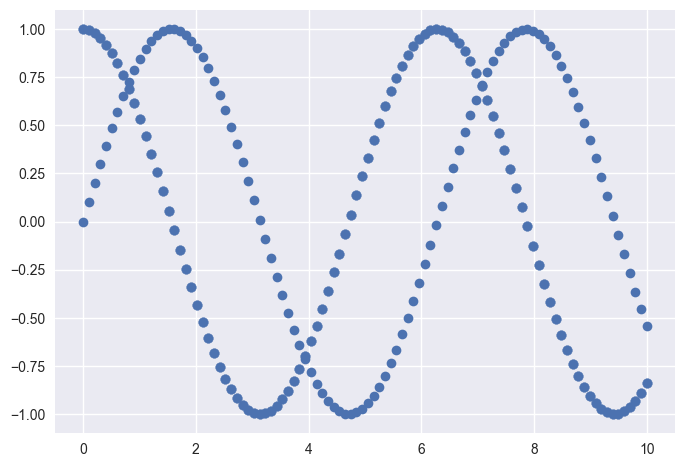

In [11]:
x = np.linspace(0, 10, 100)

plt.plot(x, np.sin(x), 'o')
plt.scatter(x, np.cos(x), marker='o')

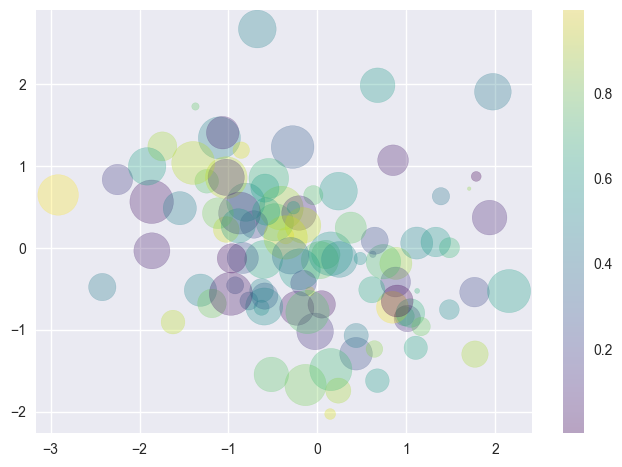

In [15]:
rng = np.random.RandomState(3)
x = rng.randn(100)
y = rng.randn(100)
colors = rng.rand(100)
sizes = 1000 * rng.rand(100)

plt.scatter(x, y, c=colors, s=sizes, alpha=0.3,
             cmap='viridis')
plt.colorbar();

In [16]:
from sklearn.datasets import load_iris
iris = load_iris()
features = iris.data.T

In [20]:
iris.data.T

array([[5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
        4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
        5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
        5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
        6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
        6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
        6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
        6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3,
        6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5,
        7.7, 7.7, 6. , 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2,
        7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6. , 6.9, 6.7, 6.9, 5.8,
        6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9],
       [3.5, 3. , 3.2, 3.1, 3.6, 3.9, 3.4, 3.4, 2.9, 3.1, 3.7, 3.4, 3. ,
        3. , 4. , 4.4, 3.9, 3.5, 3.8, 3.8, 3.4, 3.7, 3.6, 3.3, 3.4, 3. ,
       

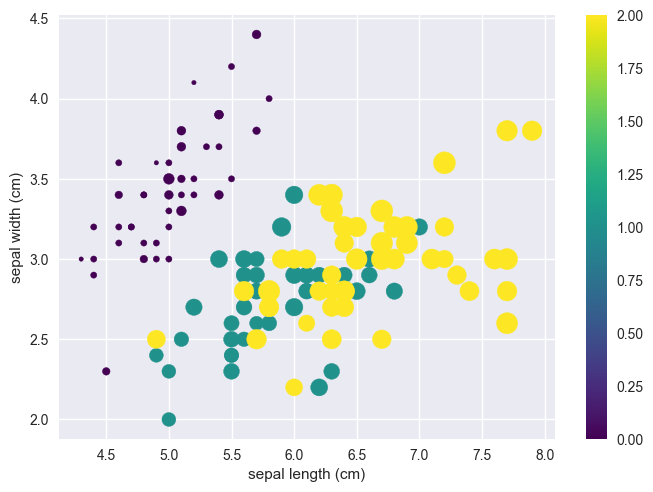

In [32]:
plt.scatter(features[0], features[1], alpha=1,
            s=100*features[3], c=iris.target, cmap='viridis')

plt.xlabel(iris.feature_names[0])

plt.ylabel(iris.feature_names[1])
plt.colorbar();

In [29]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])